In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPRegressor

import python.load_model_zone as plmz
import python.load_model_multizone as plm
from python.utils import project_path, zone_names

## Model training

In [2]:
# Read predictors
climate_filenames = {"tgw": "zonal_T2C_historical_1980_2019"}
climate_data = "tgw"
temp_data_path = f"{project_path}/data/climate/{climate_data}/{climate_filenames[climate_data]}.csv"

# Read load data
load_data_path = f"{project_path}/data/nyiso/historical_load/combined/historical_load.csv"

# Load data
temp_data, load_data = plm.load_and_prepare_data(temp_data_path, load_data_path)

### Exploratory analysis

In [3]:
# Pivot
load_data_pivot = load_data.dropna().pivot(columns='zone', index='time', values='load_MW')

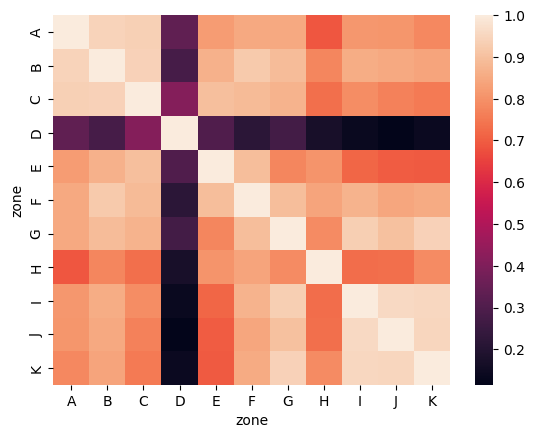

In [4]:
# There is significant correlation across zones that we
# want the model to capture!
fig, ax = plt.subplots()
sns.heatmap(load_data_pivot.corr(), ax=ax)
plt.show()

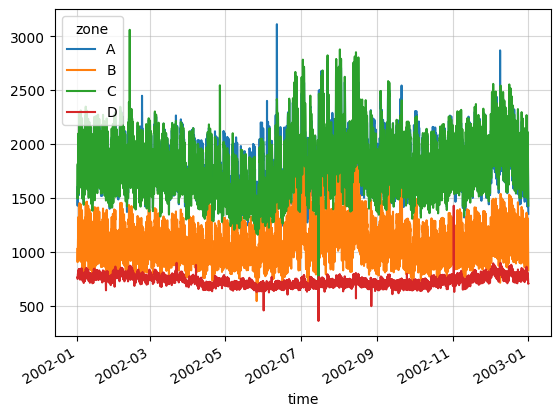

In [5]:
# Example timeseries
fig, ax = plt.subplots()
load_data_pivot[['A', 'B', 'C', 'D']].iloc[:365*24].plot(ax=ax)
ax.grid(alpha=0.5)
plt.show()

### Multi-zone model

In [9]:
# Create or load the multi-zone neural network model. This will train the model if it
# is not already stored at `modelpath`.
modelpath = f"{project_path}/data/models/load_model_{climate_data}_multizone_NN_test.pkl"

if not os.path.isfile(modelpath):
    # Specifiy model
    model = MLPRegressor(hidden_layer_sizes=(100,100), early_stopping=True, max_iter=5000)

    # Initiate
    predictor = plm.MultiZoneLoadPredictor(model=model)

    # Train
    metrics = predictor.train(temp_data, load_data, test_split=[2016])

    # Save model
    predictor.save_model(modelpath)
else:
    # Load the model
    predictor = plm.MultiZoneLoadPredictor(model=None)
    predictor.load_model(modelpath)
    # Get the fit metrics
    metrics = predictor.results['metrics']

Model loaded from /home/fs01/dcl257/projects/acorn-julia/data/models/load_model_tgw_multizone_NN_test.pkl


In [10]:
# Print evaluation metrics
for metric, value in metrics['overall'].items():
    print(f"{metric}: {value:.4f}")

rmse_train: 123.2006
mae_train: 65.2161
r2_train: 0.9181
rmse_test: 125.8143
mae_test: 64.6797
r2_test: 0.9193


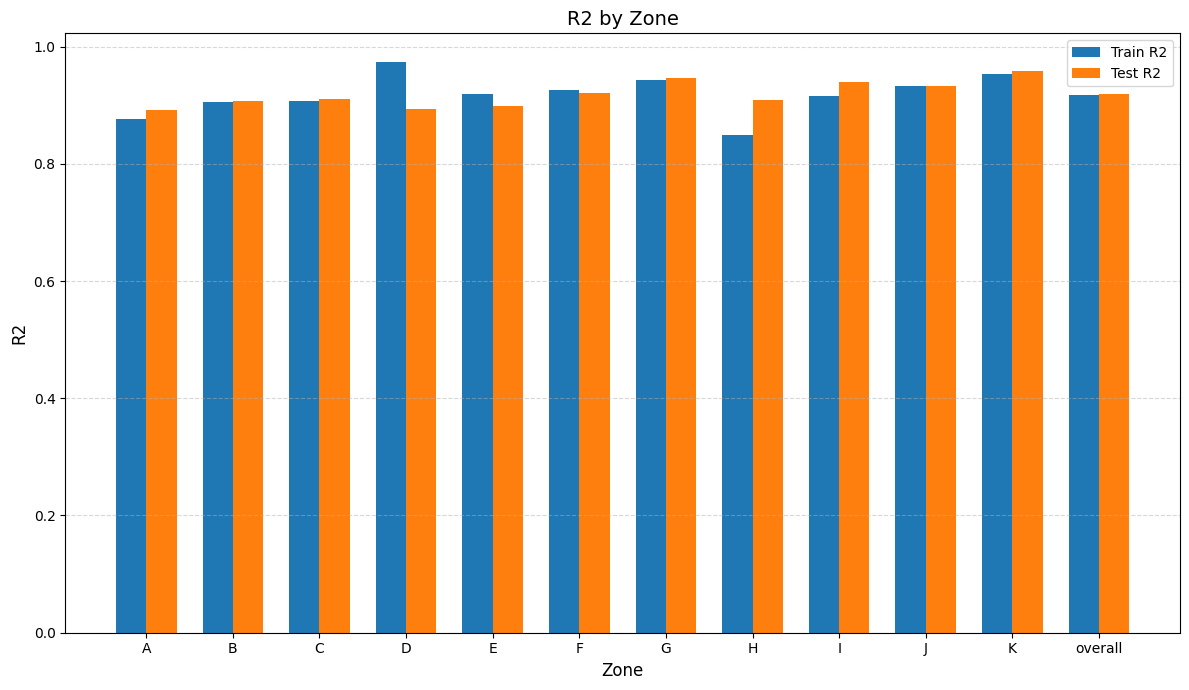

In [11]:
# Plot evaluation metrics by zone
metric_type = 'r2'
    
# Extract zone names
zones = list(metrics.keys())

# Extract train and test values for the specified metric
train_values = [metrics[zone][f"{metric_type}_train"] for zone in zones]
test_values = [metrics[zone][f"{metric_type}_test"] for zone in zones]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Set width of bars and positions
bar_width = 0.35
x = np.arange(len(zones))

# Create the grouped bars
train_bars = ax.bar(x - bar_width/2, train_values, bar_width, label=f'Train {metric_type.upper()}')
test_bars = ax.bar(x + bar_width/2, test_values, bar_width, label=f'Test {metric_type.upper()}')

# Set labels, title and legend
ax.set_xlabel('Zone', fontsize=12)
ax.set_ylabel(metric_type.upper(), fontsize=12)
ax.set_title(f'{metric_type.upper()} by Zone', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(zones)
ax.legend()

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

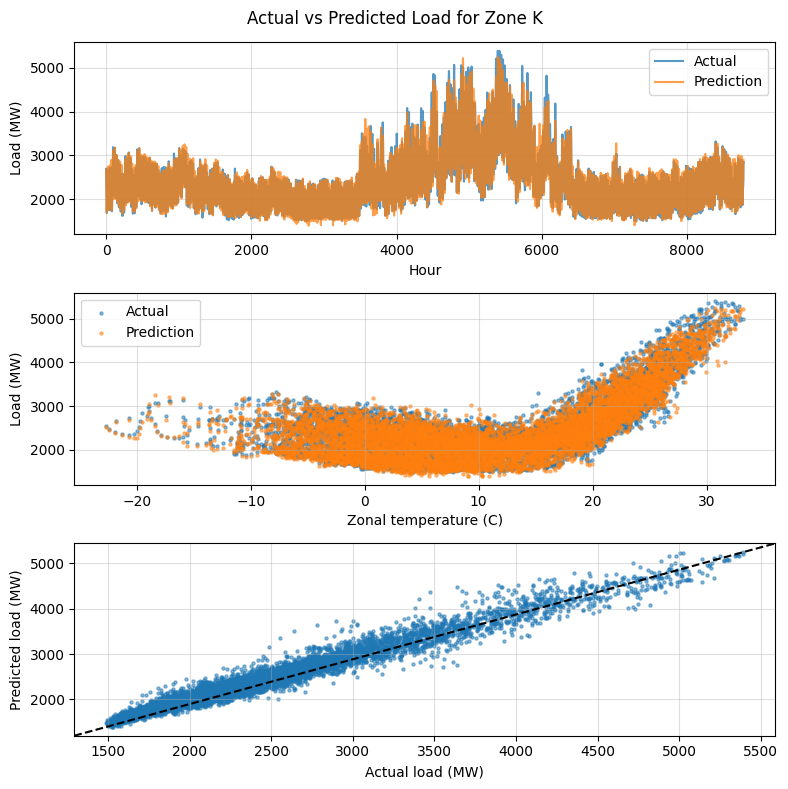

In [12]:
# Show results for given zone
predictor.plot_results('K')

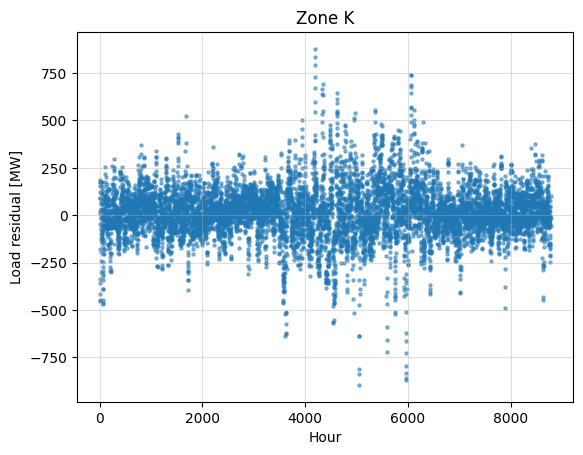

In [15]:
# Check residuals for given zone
zone = 'K'
zone_idx = predictor.zones.index(zone)

fig, ax = plt.subplots()

residuals = predictor.results['y_true_test'][:, zone_idx] - predictor.results['y_pred_test'][:, zone_idx]
residuals = residuals[predictor.results['y_true_test'][:, zone_idx] > 0]

ax.scatter(x = np.arange(len(residuals)),
           y = residuals,
           s=5, alpha=0.5)

ax.set_title(f'Zone {zone}')
ax.set_xlabel('Hour')
ax.set_ylabel('Load residual [MW]')
ax.grid(alpha=0.4)
plt.show()

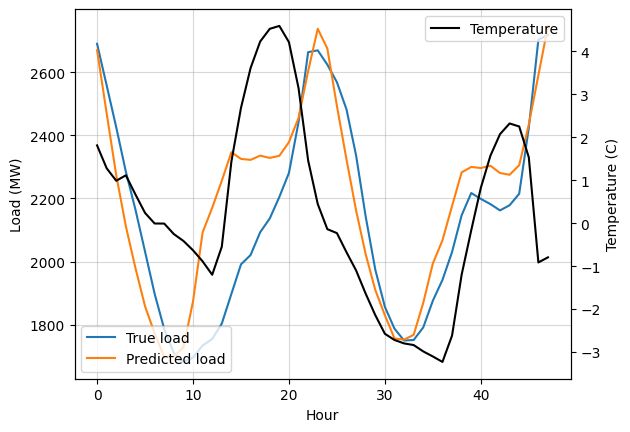

In [16]:
# Timeseries plot: winter
fig, ax = plt.subplots()
ax1 = ax.twinx()

ax.plot(predictor.results['y_true_test'][:48, zone_idx], label='True load')
ax.plot(predictor.results['y_pred_test'][:48, zone_idx], label='Predicted load')
ax.set_xlabel('Hour')
ax.grid(alpha=0.5)
ax.set_ylabel('Load (MW)')
ax.legend(loc='lower left')

ax1.plot(predictor.results['test_temps'][:48, zone_idx], color='black', label='Temperature')
ax1.legend()
ax1.set_ylabel('Temperature (C)')

plt.show()

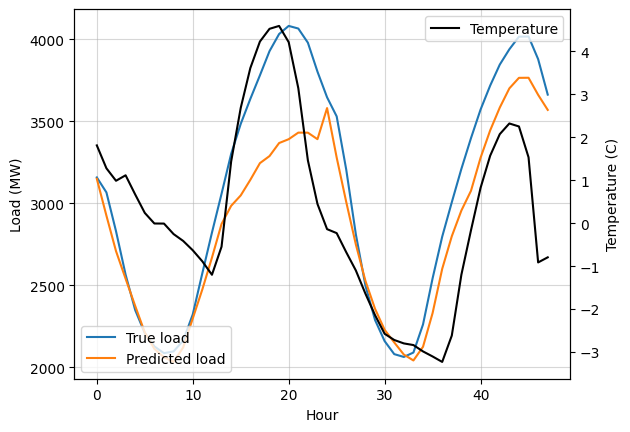

In [17]:
# Timeseries plot: summer
fig, ax = plt.subplots()
ax1 = ax.twinx()

ax.plot(predictor.results['y_true_test'][180*24:180*24+48, zone_idx], label='True load')
ax.plot(predictor.results['y_pred_test'][180*24:180*24+48, zone_idx], label='Predicted load')
ax.set_xlabel('Hour')
ax.grid(alpha=0.5)
ax.set_ylabel('Load (MW)')
ax.legend(loc='lower left')

ax1.plot(predictor.results['test_temps'][:48, zone_idx], color='black', label='Temperature')
ax1.legend()
ax1.set_ylabel('Temperature (C)')

plt.show()

## Generating new timeseries

In [157]:
import importlib
importlib.reload(plm)

<module 'python.load_model_multizone' from '/home/fs01/dcl257/projects/acorn-julia/src/python/load_model_multizone.py'>

In [158]:
# Load the model
modelpath = f"{project_path}/data/models/load_model_{climate_data}_multizone_NN_test.pkl"

predictor = plm.MultiZoneLoadPredictor(model=None)
predictor.load_model(modelpath)

Model loaded from /home/fs01/dcl257/projects/acorn-julia/data/models/load_model_tgw_multizone_NN_test.pkl


In [159]:
# Load climate input data
tgw_var_str = 'T2C'
tgw_experiment = 'rcp85hotter_2020_2059'

temp_data_path = f"{project_path}/data/climate/tgw/zonal_{tgw_var_str}_{tgw_experiment}.csv"

# Read data
new_temp_data, _ = plm.load_and_prepare_data(temp_data_path, None)

In [160]:
future_predictions = predictor.predict_future_loads(
    temp_data=new_temp_data[new_temp_data['time'].dt.year == 2059],
    temp_varname="T2C",
)

In [161]:
zone = 'A'
zone_idx = predictor.zones.index(zone)

df_test = pd.DataFrame({'datetime':predictor.results['train_datetimes'],
                        'temps':predictor.results['train_temps'][:, zone_idx],
                        'y_pred_test':predictor.results['y_pred_train'][:, zone_idx]})

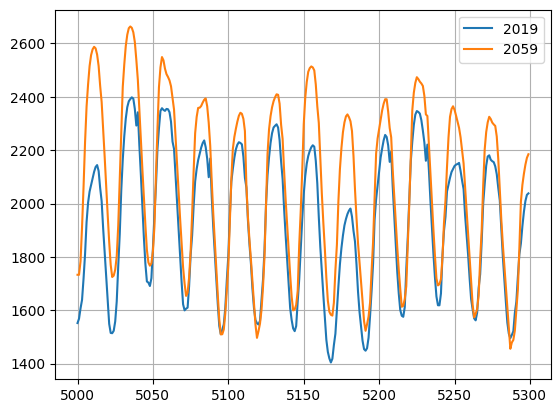

In [163]:
fig, ax = plt.subplots()

df_test[df_test['datetime'].dt.year == 2019].reset_index()['y_pred_test'][5000:5300].plot(label='2019', ax=ax)
future_predictions[(future_predictions['datetime'].dt.year == 2059)].reset_index()['A'][5000:5300].plot(label='2059', ax=ax)

ax.legend()
ax.grid()
plt.show()

In [164]:
# Distribute to bus level
df_npcc = pd.read_csv('../../data/grid/npcc_new.csv')

# Make sure sum of load ratios > 0.
mask = df_npcc.groupby('zoneID')['sumLoadP0'].transform('sum') == 0
df_npcc.loc[mask, 'sumLoadP0'] = 0.01

In [165]:
# Get zonal ratios
df_npcc = pd.merge(df_npcc,
                   pd.DataFrame(data={'zonal_sumLoadP0' : df_npcc.groupby('zoneID')['sumLoadP0'].sum()}),
                   on='zoneID', how='outer')

df_npcc['ratio'] = df_npcc['sumLoadP0']/df_npcc['zonal_sumLoadP0']

In [167]:
ratios = df_npcc[['busIdx', 'ratio', 'zoneID']].rename(columns={'busIdx':'bus_id', 'zoneID':'zone'})

In [178]:
df_out = pd.merge(future_predictions.melt(id_vars=['datetime'], var_name='zone', value_name='zonal_load_MW'),
                  ratios,
                  on='zone', how='outer')

In [179]:
df_out['load_MW'] = df_out['zonal_load_MW'] * df_out['ratio']

<Axes: >

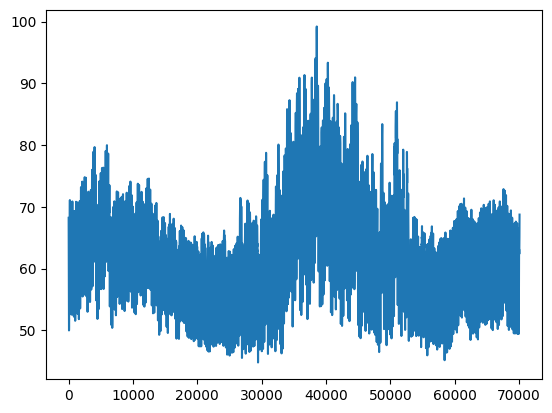

In [191]:
df_out.query('bus_id == 58')['load_MW'].plot()

## Zonal models (old!)

In [20]:
# Create a load predictor
zonal_predictor = plmz.LoadPredictor() # Default: RandomForestRegressor

# from sklearn.neural_network import MLPRegressor
# predictor = plm.LoadPredictor(model=MLPRegressor(hidden_layer_sizes=(100, 100), random_state=42))

In [32]:
# # Loop through all
# for zone in zone_names:
#     print(f"Now modeling: {zone}")
#     # Train
#     model = predictor.train(temp_data, load_data, zone, test_split=[2016])
#     # Show results
#     filepath = f"{project_path}/figs/load_model_{climate_data}_zone{zone}.pdf"
#     predictor.plot_results(zone, filepath=filepath)
#     # Save model
#     filepath=f"{project_path}/data/models/load_model_{climate_data}_zone{zone}.pkl"
#     predictor.save_model(zone, filepath=filepath)

In [22]:
# for zone in zone_names:
#     filepath=f"{project_path}/data/models/load_model_{climate_data}_zone{zone}.pkl"
#     zonal_predictor.load_model(zone, filepath = filepath)

In [49]:
print("\nBy Zone:")
for zone in predictor.zone_columns:
    print(f"\nZone {zone}:")
    for metric in ['train_r2', 'test_r2']:
        print(f"  {metric}: {zonal_predictor.zone_models[zone]['metrics'][metric]}")


By Zone:

Zone A:
  train_r2: 0.9356197600237405
  test_r2: 0.431593111331694

Zone B:
  train_r2: 0.9295739117642258
  test_r2: 0.45974918836319134

Zone C:
  train_r2: 0.9324817220362195
  test_r2: 0.3937280588686408

Zone D:
  train_r2: 0.9938219556882089
  test_r2: 0.6636331897861913

Zone E:
  train_r2: 0.9393521680304869
  test_r2: 0.36277739637509

Zone F:
  train_r2: 0.9349472362452553
  test_r2: 0.44170775430665665

Zone G:
  train_r2: 0.940633839340587
  test_r2: 0.5523183452347395

Zone H:
  train_r2: 0.9499927733265421
  test_r2: 0.45034343764516793

Zone I:
  train_r2: 0.9462769990924754
  test_r2: 0.5875547898860385

Zone J:
  train_r2: 0.9389805910633277
  test_r2: 0.5800722893396236

Zone K:
  train_r2: 0.9541427993396298
  test_r2: 0.6789042237906777


In [34]:
# Gather all predictions
df_pred = []
for zone in zone_names:
    df_pred.append(zonal_predictor.zone_models[zone]['test_results'].set_index('datetime')[['y_pred']].rename(columns={'y_pred':zone}))

df_pred = pd.concat(df_pred, axis=1)

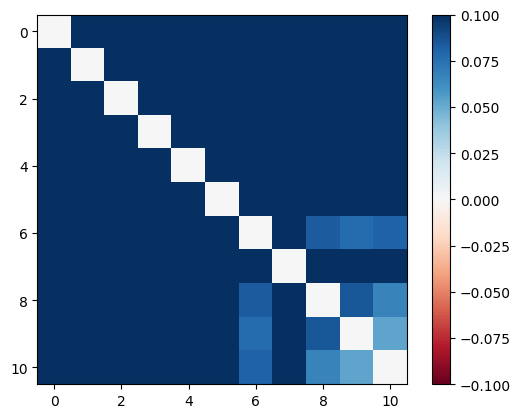

In [43]:
# Check correlational differences
load_data_pivot = load_data[load_data['time'].dt.year == 2016].pivot(index='time', columns='zone')

fig, ax = plt.subplots()
image = ax.imshow(load_data_pivot.corr().to_numpy() - df_pred.corr().to_numpy(), vmin=-0.1, vmax=0.1, cmap='RdBu')
plt.colorbar(image)
plt.show()